[Link to Campbell et al. 2018 manuscript](https://www.ncbi.nlm.nih.gov/pubmed/30054031)

## Import statements

In [1]:
from scipy.integrate import odeint
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd 

## Reproduction of the model in the paper

### Model schematic from Campbell et al. 2018
![Model schematic from Campbell et al. 2018](img/model_scheme.png)

In [2]:

## ----------------------------
## Thin filament transitions
## ----------------------------
# N_off : binding sites on the thin filament at which myosin heads could not attach too (Inactive state)
# N_on : binding sites on the thin filament which are available for mysoin binding (Active state)
# J_on : the number of sites per unit time switching from N_on to N_off
# J_off : flux of binding sites through the off transition
# k_coop : constant that defines the strength of thin filament cooperativity
# N_overlap - N_on: the number of binding sites that overlap with the thick filament are available to the mysoin heads
# N_on - N_bound: the number of unbound sites (sites that has no myosin bound but are active)

## -----------------------------
## Thick filament transitions 
## -----------------------------
# M_off : the proportion of mysoin heads in the off state
# M_on: the proportion of myosin heads in the on state
# M_FG: the proportion of cross-bridgess attached to actin with spring lengths beween x and x + dx
# J_1: the flux of mysoin heads transition from M_off to M_on state depending on the total force and phosphorylation state of RLCs
# J_2: the flux of myosin heads ino the off state
# J_3: the flux of myosin heads binding to actin
# J_4: the flux of myosin detachement step 


## Scalers for scaling the parameters to have units in nm, nM, ms and N
dm = 1e9 # convert m to nm
dnm = 1 # convert nm to nm
ds = 1e3 # convert sec to msec
dms = 1 # convert msec to msec
dM = 1e9 # convert molar to nano molar
dnM = 1 # convert nano molar to nano molar

def filament_model(state, t, Ca, p):
    N_on, N_off, M_on, M_off, *M_FG = state
    
    H = p['H'] ## 1 Phosphorylated RLC, 0 otherwise
    n = p['n'] ##XB populations evaluated with 0.5 nM resolution over range -10nm <= x <= 10
    k_on = p['k_on'] / dM / ds #nM-1 ms-1
    N_overlap = p['N_overlap']
    k_coop = p['k_coop']
    k_off = p['k_off'] / ds #ms-1
    k_1 = p['k_1'] / ds  #ms-1
    k_MLCP = p['k_MLCP'] / ds  #ms-1
    k_force = p['k_force'] * dm * dm #N-1 nm2
    k_2 = p['k_2'] / ds ## ms-1 ??
    k_3 = p['k_3'] / dnm / ds #nm-1 ms-1
    k_40 = p['k_40'] / ds  #ms-1
    k_41 = p['k_41'] / dnm / dnm / dnm / dnm #10 # ?? nm-4
    x_ps = p['x_ps'] * dnm #nm
    k_cb = p['k_cb'] / dm  ### N nm-1??
    N_0 = p['N_0'] / dm / dm ##nm-2
    k_B = p['k_B'] * dm  # N nm K-1
    T = p['T'] # K Temperature
    k_p = p['k_p'] / dm / dm # N nm-2 nm-1
    L_0 = p['L_0'] * dnm
    L = p ['L'] * dnm

    x = np.linspace(-10, 10, n) # Cross-bridge populations were evaluated with 0.5 nm resolution over the range -10 nm < x <10 nm.


    Ca = Ca #nM
    N_bound = sum(M_FG) #

    
    
    F_passive = k_p * (L - L_0)
        
    F_active = N_0 * k_cb * sum([M_FG[ii] * (x[ii] + x_ps) for ii in range(n)])
    F_total = F_active + F_passive
    
    
    J_on = k_on * Ca * (N_overlap - N_on) * (1 + k_coop * (N_on / N_overlap))
    J_off = k_off * (N_on - N_bound) * (1 + k_coop * (N_overlap - N_on) / N_overlap)
    
    J_1 = (k_1 + H * k_MLCP)*(1 + k_force * F_total) * M_off
    J_2 = k_2 * M_on

    
    d_N_on = J_on - J_off
    d_N_off = -J_on + J_off
    d_M_off = -J_1 + J_2

    J_3 = np.zeros(n)
    J_4 = np.zeros(n)
    d_M_FG = np.zeros(n)
    
    for ii in range(n):
        J_3[ii] = k_3 * np.exp((-k_cb * x[ii]**2) / (2 * k_B * T)) * M_on * (N_on - N_bound)
        J_4[ii] = (k_40 + k_41 * (x[ii] - x_ps)**4) * M_FG[ii]
        d_M_FG[ii]  = J_3[ii] - J_4[ii]

    d_M_on = (J_1 + sum(J_4)) - (J_2 + sum(J_3))
    
    return [d_N_on, d_N_off, d_M_on, d_M_off] + list(d_M_FG)



## Force calcium test with the model and function to fit the curve

In [3]:
def f_ca_test(pars = {}):

    p = {'H' : 1, 'n' : 41 , 'k_on' : 2.08e7,  'N_overlap' : 1, 'k_coop' : 5.7,
         'k_off' : 100, 'k_1' : 6.17,  'k_MLCP' : 1.48, 'k_force' : 1.74e-4, 
         'k_2' : 200, 'k_3' : 7.11, 'k_40' : 1.69, 'k_41' : 10,
         'x_ps' : 1.4, 'k_cb' : 0.001, 'N_0' : 6.9e16, 'k_B' : 1.38e-23, 'T' : 310.15,
         'k_p': 28.7, 'L_0':907, 'L':1900}

    
    if len(pars) > 0:
        for k, v in pars.items():
            if not (k in p.keys()):
                raise NameError("Parameter %s is not in the model" % (k))
            p[k] = v

    x = np.linspace(-10 , 10, p['n']) # Cross-bridge populations were evaluated with 0.5 nm resolution over the range -10 nm < x < 10 nm.
    Fmax = []
    ca_list = np.logspace(3, 4, 100) # calcium concentration in the range 10^-3 to 10^-5 nM
    init = [0, 1, 0, 1] + [0] * p['n'] ## initial conditions
    t_start, t_end, n_pts = 0, 5000, 5000
    for ii in ca_list:
        t = np.linspace(t_start, t_end, n_pts)
        Ca = ii
        sol = odeint(filament_model, init, t, args=(Ca, p))
        init = sol[-1,:]
     
        F_active = p['N_0'] / dm / dm * p['k_cb'] / dm * sum([sol[:, ii + 4] * (x[ii] + p['x_ps']) for ii in range(p['n'])])
        F_passive = p['k_p'] / dm / dm * (p['L'] - p['L_0'])
        Fmax.append(np.max(F_active + F_passive))

    return ca_list, Fmax


def f_ca_func(ca, h, ca50, fmax, fmin):
    return fmin + fmax * ca**h/ (ca**h + ca50**h)


def f_ca_fit(ca, force):
    popt, pcov = curve_fit(f_ca_func, ca, force, p0 = [7, 1000, max(force), min(force)])
    return popt

## Example simulatiions (Simulation +MLCK and two sarcomere lengths)

In [4]:
ca_list1, fmax1 = f_ca_test(pars = {'H': 1, 'N_overlap':0.4}) 
ca_list2, fmax2 = f_ca_test(pars = {'H': 1, 'N_overlap':0.8})
#ca_list3, fmax3 = f_ca_test(pars = {'H': 1, 'N_overlap':1, 'k_force':0})
popt1 = f_ca_fit(ca_list1, np.array(fmax1)*1e15)
popt2 = f_ca_fit(ca_list2, np.array(fmax2)*1e15)

/home/jaimit/Documents/m2hvenv/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


(6, 5)

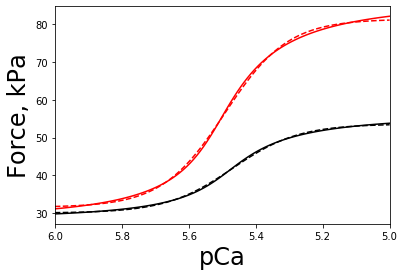

In [5]:
fig, ax = plt.subplots(1, 1)
ax.plot(-np.log10(ca_list1/1000) + 6, np.array(fmax1) * 1e15, 'k-')
ax.plot(-np.log10(ca_list2/1000) + 6, np.array(fmax2) * 1e15, 'r-')

ax.plot(-np.log10(ca_list1/1000) + 6,f_ca_func(ca_list1, *popt1), 'k--')
ax.plot(-np.log10(ca_list2/1000) + 6,f_ca_func(ca_list2, *popt2), 'r--')

ax.set_xlabel('pCa', fontsize  = 24)
ax.set_ylabel('Force, kPa', fontsize = 24)
ax.set_xlim([6, 5])


In [8]:
df = pd.DataFrame([popt1, popt2], columns=['n', 'Ca50', 'fmax', 'fmin'])
df.index = ['SL1', 'SL2']
df['pCa'] = -np.log10(df['Ca50']/1000) + 6
df['color'] = ['black', 'red']
df[['n', 'pCa', 'color']]

,n,pCa,color
SL1,4.389936,5.469945,black
SL2,4.612817,5.492001,red


### Increase in sarcomere length increases calcium sensisitivity (similar to the paper), however, the Hill coefficient had modest increase with increase in length (unlike the paper where increase in sarcomere length is reported to result in large decrease in the Hill coefficient) 